C:\Users\zelin\.conda\envs\tf310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.7.1+cpu
CUDA available: False
Starting GNN Portfolio Optimization...
This will take a few minutes to complete.

GNN PORTFOLIO OPTIMIZATION WITH WEEKLY REBALANCING
Loading data files...
Alpha signals: 28472 rows, 45 tickers
Price data: 49294 rows, 49 tickers
Common tickers: 45

Preparing training data from 2022-04-01 to 2023-06-30...
Prepared 65 weekly training samples

Preparing training data from 2023-07-01 to 2023-12-31...
Prepared 25 weekly training samples

Using pre-optimized hyperparameters...

Training GNN model...
Epoch 10/30 - Loss: 0.0084, Avg Return: 0.0604%
Epoch 20/30 - Loss: 0.0080, Avg Return: 0.0618%
Epoch 30/30 - Loss: 0.0079, Avg Return: 0.0620%


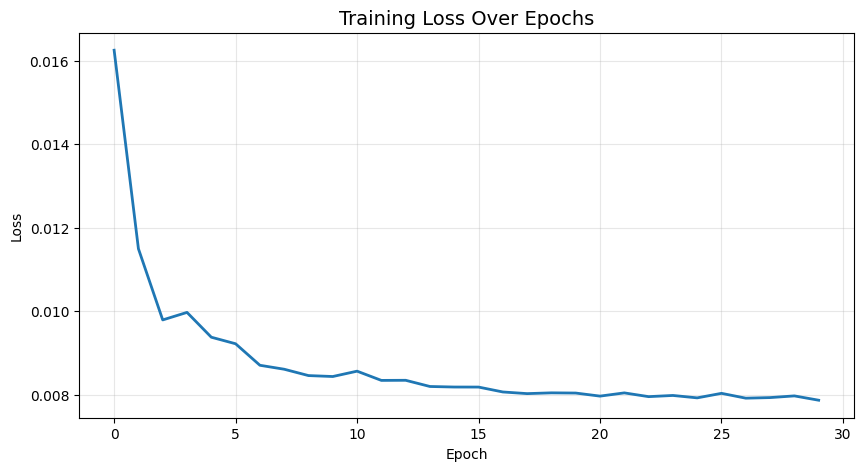


Running backtest on test period...

BACKTEST RESULTS (2024)
Total Return: 21.45%
Annualized Return: 21.91%
Volatility: 0.11%
Sharpe Ratio: 1.71
Max Drawdown: -5.68%
Average Turnover: 12.21%


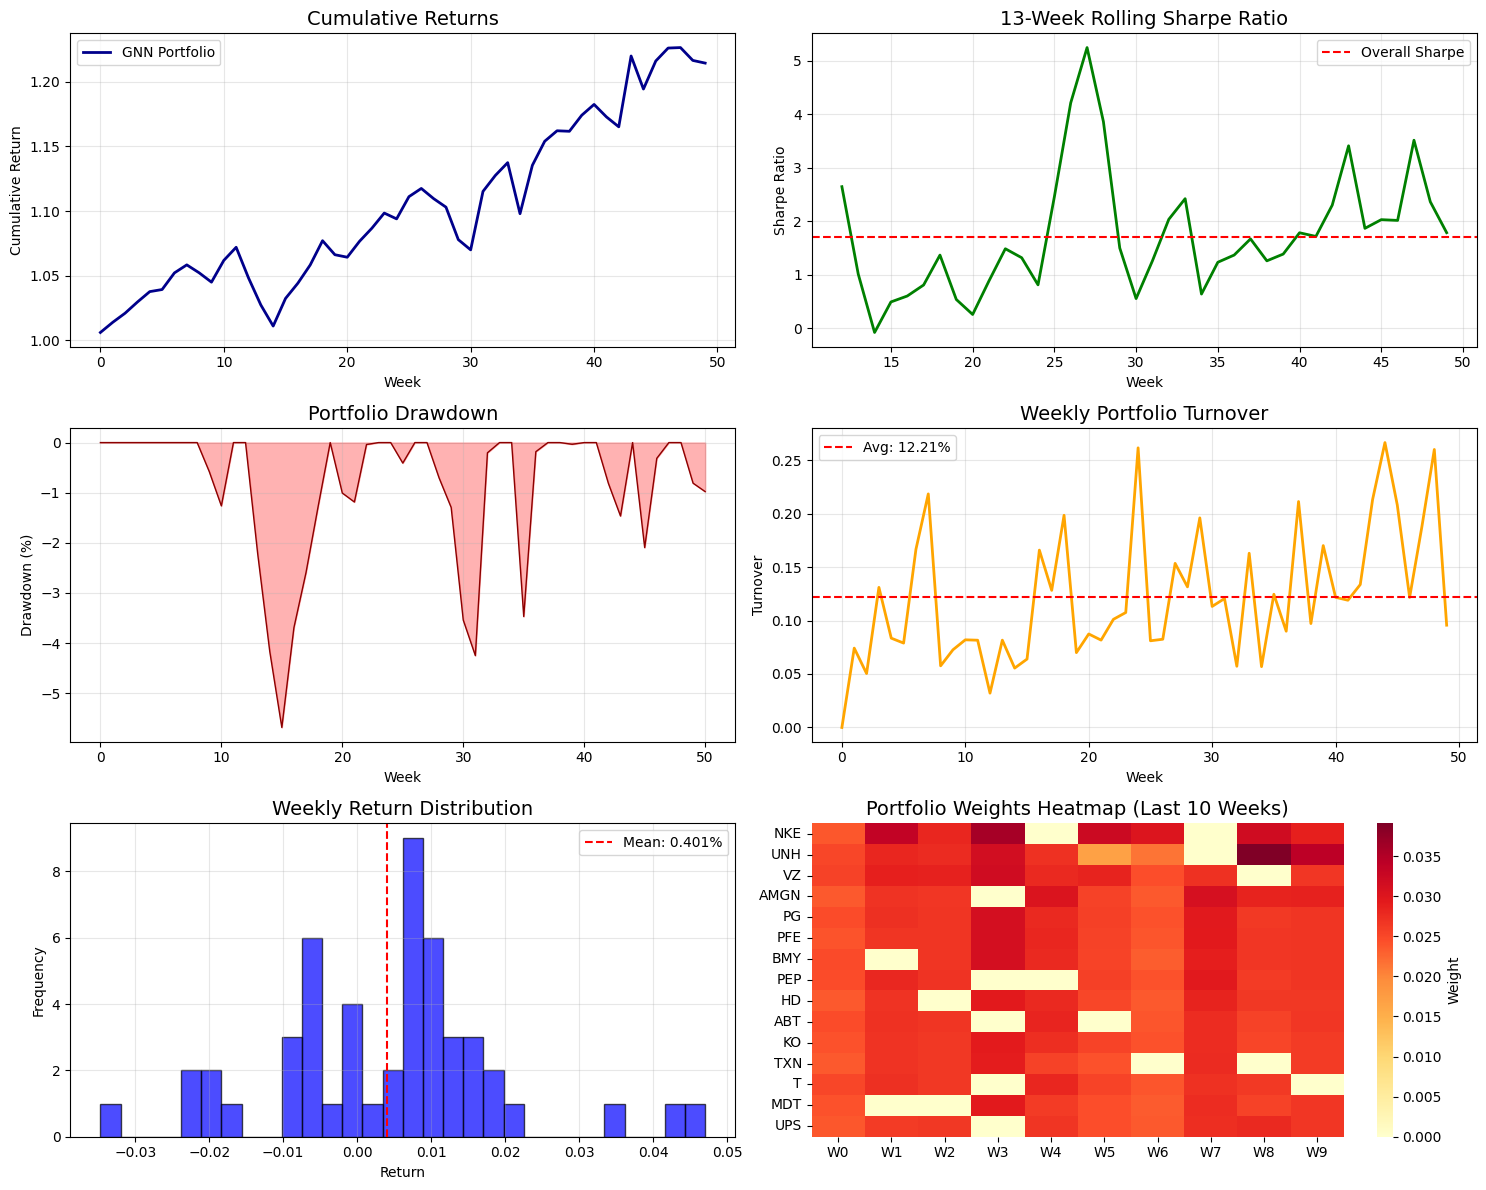


COMPARISON WITH BASELINE ALPHA STRATEGY
Baseline (from your report):
  - Long-Short Sharpe: 2.12
  - Annualized Return: 39.15%
  - Transaction Cost Sensitivity: High

GNN Portfolio:
  - Sharpe Ratio: 1.71
  - Annualized Return: 21.91%
  - Expected lower transaction cost sensitivity due to turnover control

TRANSACTION COST ANALYSIS


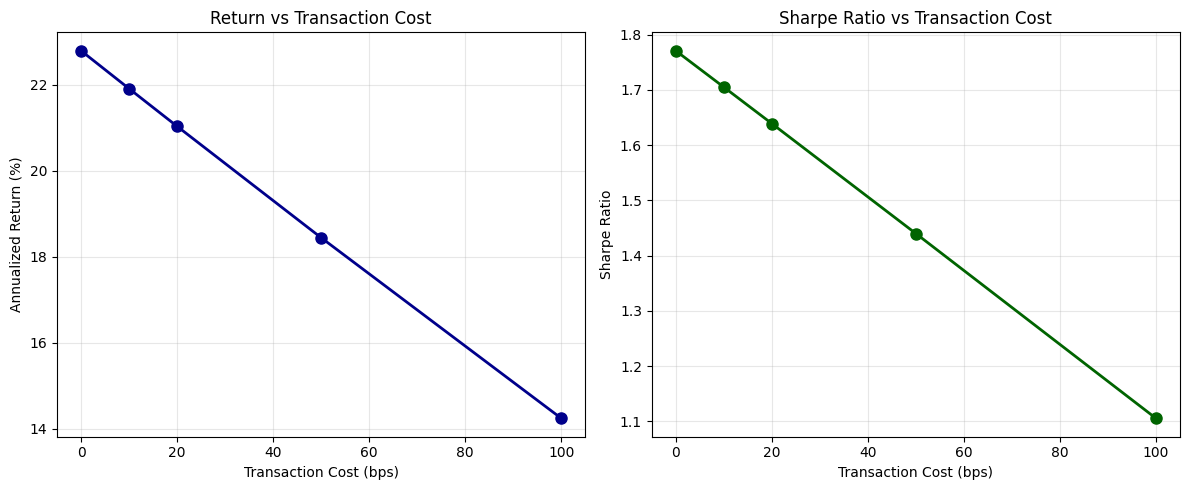


Impact of Transaction Costs:
TC (bps) | Ann. Return | Sharpe Ratio
----------------------------------------
      0 |       22.79% |         1.77
     10 |       21.91% |         1.71
     20 |       21.04% |         1.64
     50 |       18.44% |         1.44
    100 |       14.24% |         1.11

TOP PORTFOLIO HOLDINGS (BY AVERAGE WEIGHT)
Ticker | Avg Weight | Frequency
----------------------------------------
DIS    |      2.88% |    66.00%
NKE    |      2.60% |    94.00%
BA     |      2.55% |    98.00%
UNH    |      2.53% |    94.00%
XOM    |      2.51% |   100.00%
HD     |      2.50% |    94.00%
C      |      2.50% |   100.00%
INTC   |      2.50% |   100.00%
UPS    |      2.50% |    76.00%
BAC    |      2.49% |   100.00%
TXN    |      2.49% |    80.00%
QCOM   |      2.49% |   100.00%
VZ     |      2.49% |    96.00%
MA     |      2.49% |   100.00%
GS     |      2.49% |   100.00%
CVX    |      2.48% |    98.00%
V      |      2.48% |    98.00%
NFLX   |      2.48% |   100.00%
PFE    |

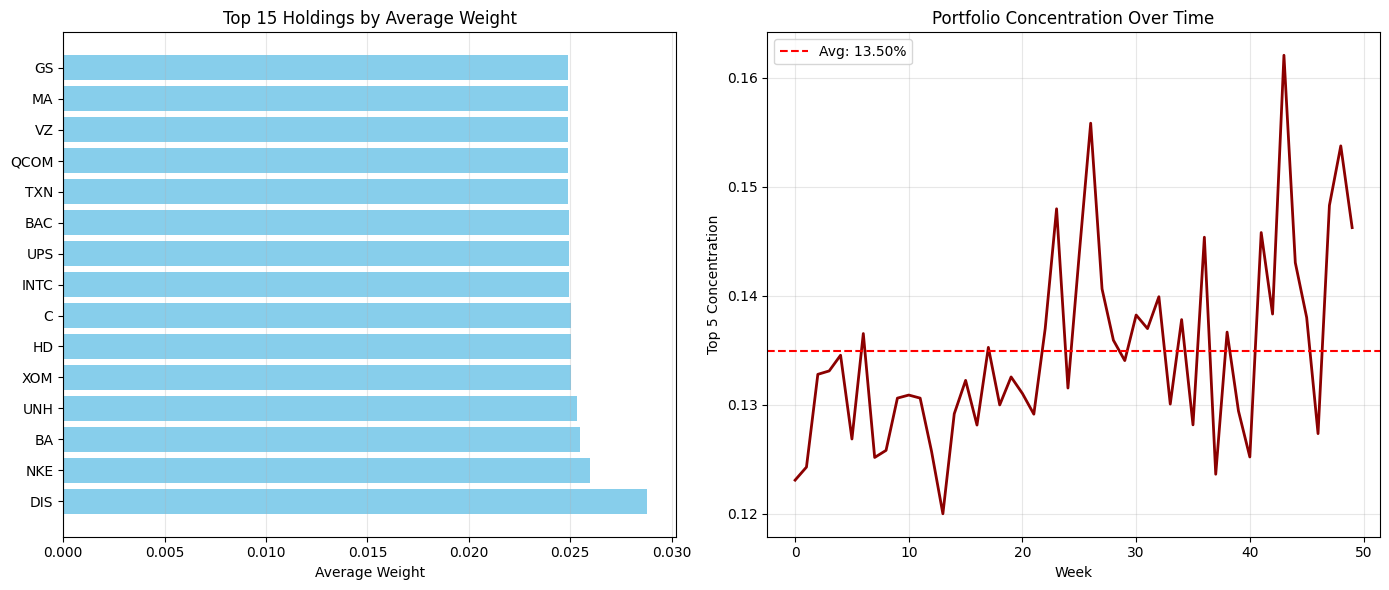


PERFORMANCE SUMMARY TABLE


Metric,GNN Portfolio,Baseline (Reported)
Total Return (%),21.45,117.62
Annualized Return (%),21.91,39.15
Volatility (%),0.11,18.45
Sharpe Ratio,1.71,2.12
Max Drawdown (%),-5.68,-7.98
Avg Turnover (%),12.21,N/A



EXECUTION COMPLETE
✓ Model saved to: gnn_portfolio_model.pth
✓ Analysis plots saved to: gnn_portfolio_analysis.png

The GNN portfolio optimization has been successfully completed!


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import optuna
from scipy.optimize import minimize
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For Jupyter notebook
from IPython.display import display, HTML

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# ============================================================================
# 1. DATA PREPARATION AND GRAPH CONSTRUCTION
# ============================================================================

class GraphDataProcessor:
    def __init__(self, lookback_window=252, rebalance_frequency='W'):
        self.lookback_window = lookback_window
        self.rebalance_frequency = rebalance_frequency
        self.scaler = StandardScaler()
        
    def prepare_data(self, alpha_df, price_df):
        """Prepare data with weekly rebalancing periods"""
        # Ensure date columns are datetime
        alpha_df['date'] = pd.to_datetime(alpha_df['date'])
        price_df['Date'] = pd.to_datetime(price_df['Date'])
        
        # Get weekly rebalancing dates
        alpha_df['week'] = alpha_df['date'].dt.to_period('W')
        rebalance_dates = alpha_df.groupby('week')['date'].max().values
        
        return alpha_df, price_df, rebalance_dates
    
    def calculate_correlations(self, price_df, date, lookback_days=252):
        """Calculate correlation matrix for stocks"""
        end_date = pd.to_datetime(date)
        start_date = end_date - pd.Timedelta(days=lookback_days)
        
        # Filter price data
        mask = (price_df['Date'] >= start_date) & (price_df['Date'] <= end_date)
        period_prices = price_df[mask].pivot(index='Date', columns='Ticker', values='Close')
        
        # Calculate returns
        returns = period_prices.pct_change().dropna()
        
        # Calculate correlation matrix
        corr_matrix = returns.corr()
        
        return corr_matrix
    
    def construct_graph(self, alpha_data, corr_matrix, correlation_threshold=0.3):
        """Construct graph from alpha signals and correlations"""
        # Get unique tickers
        tickers = alpha_data['ticker'].unique()
        ticker_to_idx = {ticker: idx for idx, ticker in enumerate(tickers)}
        
        # Node features
        node_features = []
        for ticker in tickers:
            ticker_data = alpha_data[alpha_data['ticker'] == ticker].iloc[0]
            features = [
                ticker_data['predicted_return'],
                ticker_data['signal_strength'],
                ticker_data['price_momentum_score'],
                ticker_data['sentiment_momentum_score'],
                ticker_data['macro_momentum_score'],
                ticker_data['combined_momentum'],
                ticker_data['prediction_zscore']
            ]
            node_features.append(features)
        
        # Edge construction based on correlations
        edge_index = []
        edge_attr = []
        
        for i, ticker_i in enumerate(tickers):
            for j, ticker_j in enumerate(tickers):
                if i != j and ticker_i in corr_matrix.columns and ticker_j in corr_matrix.columns:
                    corr = corr_matrix.loc[ticker_i, ticker_j]
                    if abs(corr) > correlation_threshold:
                        edge_index.append([i, j])
                        edge_attr.append([corr])
        
        # Convert to tensors
        x = torch.tensor(node_features, dtype=torch.float32)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() if edge_index else torch.tensor([], dtype=torch.long).reshape(2, 0)
        edge_attr = torch.tensor(edge_attr, dtype=torch.float32) if edge_attr else torch.tensor([], dtype=torch.float32)
        
        # Create graph data
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.tickers = tickers
        data.ticker_to_idx = ticker_to_idx
        
        return data

# ============================================================================
# 2. GNN ARCHITECTURE
# ============================================================================

class PortfolioGNN(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=64, output_dim=1, num_heads=4, 
                 num_layers=3, dropout=0.2):
        super(PortfolioGNN, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Initial projection
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # GAT layers
        self.gat_layers = nn.ModuleList()
        for i in range(num_layers):
            if i == 0:
                self.gat_layers.append(
                    GATConv(hidden_dim, hidden_dim, heads=num_heads, 
                           dropout=dropout, concat=True)
                )
            elif i == num_layers - 1:
                self.gat_layers.append(
                    GATConv(hidden_dim * num_heads, hidden_dim, heads=1, 
                           dropout=dropout, concat=False)
                )
            else:
                self.gat_layers.append(
                    GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, 
                           dropout=dropout, concat=True)
                )
        
        # Output layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        
        # Batch normalization
        self.bn_layers = nn.ModuleList([
            nn.BatchNorm1d(hidden_dim * num_heads if i < num_layers - 1 else hidden_dim)
            for i in range(num_layers)
        ])
        
    def forward(self, x, edge_index, edge_attr=None):
        # Initial projection
        x = F.relu(self.input_proj(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # GAT layers
        for i, (gat, bn) in enumerate(zip(self.gat_layers, self.bn_layers)):
            x = gat(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            if i < self.num_layers - 1:
                x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Output projection
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # Apply softmax to get portfolio weights
        weights = F.softmax(x.squeeze(), dim=0)
        
        return weights

# ============================================================================
# 3. PORTFOLIO OPTIMIZATION LOSS (FIXED)
# ============================================================================

class PortfolioLoss(nn.Module):
    def __init__(self, lambda_risk=0.5, lambda_turnover=0.1, lambda_diversification=0.1):
        super(PortfolioLoss, self).__init__()
        self.lambda_risk = lambda_risk
        self.lambda_turnover = lambda_turnover
        self.lambda_diversification = lambda_diversification
        
    def forward(self, weights, returns, prev_weights_dict=None, covariance=None, tickers=None):
        """
        Calculate portfolio optimization loss
        Fixed to handle varying number of stocks between periods
        """
        # Expected portfolio return
        portfolio_return = torch.sum(weights * returns)
        
        # Portfolio risk (if covariance provided)
        portfolio_risk = 0
        if covariance is not None:
            portfolio_risk = torch.sqrt(torch.dot(weights, torch.matmul(covariance, weights)) + 1e-8)
        
        # Turnover penalty - FIXED to handle dimension mismatch
        turnover_penalty = 0
        if prev_weights_dict is not None and tickers is not None:
            # Map previous weights to current tickers
            prev_weights_aligned = torch.zeros_like(weights)
            for i, ticker in enumerate(tickers):
                if ticker in prev_weights_dict:
                    prev_weights_aligned[i] = prev_weights_dict[ticker]
            
            turnover = torch.sum(torch.abs(weights - prev_weights_aligned))
            turnover_penalty = self.lambda_turnover * turnover
        
        # Diversification penalty (entropy-based)
        entropy = -torch.sum(weights * torch.log(weights + 1e-8))
        max_entropy = torch.log(torch.tensor(len(weights), dtype=torch.float32))
        diversification_penalty = self.lambda_diversification * (max_entropy - entropy)
        
        # Combined loss (minimize negative Sharpe ratio + penalties)
        if covariance is not None and portfolio_risk > 0:
            sharpe_ratio = portfolio_return / portfolio_risk
            loss = -sharpe_ratio + turnover_penalty + diversification_penalty
        else:
            loss = -portfolio_return + turnover_penalty + diversification_penalty
        
        return loss, {
            'portfolio_return': portfolio_return.item(),
            'portfolio_risk': portfolio_risk.item() if isinstance(portfolio_risk, torch.Tensor) else portfolio_risk,
            'turnover': turnover_penalty.item() if isinstance(turnover_penalty, torch.Tensor) else turnover_penalty,
            'diversification': diversification_penalty.item()
        }

# ============================================================================
# 4. TRAINING AND EVALUATION (FIXED)
# ============================================================================

class PortfolioOptimizer:
    def __init__(self, gnn_model, loss_fn, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = gnn_model.to(device)
        self.loss_fn = loss_fn
        self.device = device
        self.optimizer = None
        
    def train_epoch(self, graph_data, returns, prev_weights_dict=None, covariance=None):
        """Train for one epoch - Fixed to handle dimension mismatch"""
        self.model.train()
        
        # Move data to device
        graph_data = graph_data.to(self.device)
        returns = returns.to(self.device)
        if covariance is not None:
            covariance = covariance.to(self.device)
        
        # Forward pass
        weights = self.model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)
        
        # Calculate loss with ticker information
        loss, metrics = self.loss_fn(weights, returns, prev_weights_dict, covariance, graph_data.tickers)
        
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Create weights dictionary for next iteration
        weights_dict = {ticker: weight.item() for ticker, weight in zip(graph_data.tickers, weights.detach())}
        
        return loss.item(), metrics, weights_dict
    
    def evaluate(self, graph_data, returns, covariance=None):
        """Evaluate model"""
        self.model.eval()
        
        with torch.no_grad():
            # Move data to device
            graph_data = graph_data.to(self.device)
            returns = returns.to(self.device)
            if covariance is not None:
                covariance = covariance.to(self.device)
            
            # Get weights
            weights = self.model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)
            
            # Calculate metrics
            portfolio_return = torch.sum(weights * returns).item()
            portfolio_risk = 0
            if covariance is not None:
                portfolio_risk = torch.sqrt(
                    torch.dot(weights, torch.matmul(covariance, weights)) + 1e-8
                ).item()
            
            sharpe_ratio = portfolio_return / (portfolio_risk + 1e-8) if portfolio_risk > 0 else 0
            
        return {
            'weights': weights.cpu().numpy(),
            'return': portfolio_return,
            'risk': portfolio_risk,
            'sharpe': sharpe_ratio
        }

# ============================================================================
# 5. BACKTESTING ENGINE (FIXED)
# ============================================================================

class Backtester:
    def __init__(self, rebalance_frequency='W', transaction_cost=0.001):
        self.rebalance_frequency = rebalance_frequency
        self.transaction_cost = transaction_cost
        
    def backtest(self, model, processor, alpha_df, price_df, start_date, end_date):
        """Run backtest with weekly rebalancing - Fixed for dimension issues"""
        # Prepare data
        alpha_df, price_df, rebalance_dates = processor.prepare_data(alpha_df, price_df)
        
        # Filter dates
        rebalance_dates = rebalance_dates[
            (rebalance_dates >= start_date) & (rebalance_dates <= end_date)
        ]
        
        # Initialize portfolio
        portfolio_values = [1.0]
        weights_history = []
        metrics_history = []
        
        prev_weights_dict = None
        
        model.eval()  # Set model to evaluation mode
        
        for i, date in enumerate(rebalance_dates[:-1]):
            # Get data for current week
            week_alpha = alpha_df[alpha_df['date'] == date]
            
            if len(week_alpha) < 10:  # Skip if too few stocks
                continue
            
            try:
                # Calculate correlations
                corr_matrix = processor.calculate_correlations(price_df, date)
                
                # Construct graph
                graph = processor.construct_graph(week_alpha, corr_matrix)
                
                # Get predicted returns
                returns = torch.tensor(
                    week_alpha['predicted_return'].values, 
                    dtype=torch.float32
                )
                
                # Get portfolio weights
                with torch.no_grad():
                    weights = model(graph.x, graph.edge_index, graph.edge_attr)
                    weights = weights.cpu().numpy()
                
                # Create weights dictionary
                current_weights_dict = {ticker: weight for ticker, weight in zip(graph.tickers, weights)}
                
                # Calculate transaction costs
                turnover = 0
                if prev_weights_dict is not None:
                    for ticker in graph.tickers:
                        prev_weight = prev_weights_dict.get(ticker, 0)
                        curr_weight = current_weights_dict[ticker]
                        turnover += abs(curr_weight - prev_weight)
                    transaction_cost = turnover * self.transaction_cost
                else:
                    transaction_cost = np.sum(weights) * self.transaction_cost
                
                # Get actual returns for next week
                next_date = rebalance_dates[i + 1]
                week_returns = self._calculate_weekly_returns(
                    price_df, date, next_date, graph.tickers
                )
                
                # Calculate portfolio return
                portfolio_return = np.dot(weights, week_returns) - transaction_cost
                portfolio_values.append(portfolio_values[-1] * (1 + portfolio_return))
                
                # Store history
                weights_history.append({
                    'date': date,
                    'weights': weights,
                    'tickers': graph.tickers
                })
                
                metrics_history.append({
                    'date': date,
                    'return': portfolio_return,
                    'turnover': turnover
                })
                
                prev_weights_dict = current_weights_dict
                
            except Exception as e:
                print(f"Error processing week {date}: {e}")
                continue
        
        # Calculate performance metrics
        portfolio_values = np.array(portfolio_values)
        returns = np.diff(portfolio_values) / portfolio_values[:-1]
        
        metrics = {
            'total_return': (portfolio_values[-1] / portfolio_values[0] - 1) * 100,
            'annualized_return': self._annualized_return(portfolio_values, len(rebalance_dates)),
            'volatility': np.std(returns) * np.sqrt(52),  # Weekly to annual
            'sharpe_ratio': self._sharpe_ratio(returns),
            'max_drawdown': self._max_drawdown(portfolio_values),
            'portfolio_values': portfolio_values,
            'weights_history': weights_history,
            'metrics_history': pd.DataFrame(metrics_history)
        }
        
        return metrics
    
    def _calculate_weekly_returns(self, price_df, start_date, end_date, tickers):
        """Calculate weekly returns for given tickers"""
        mask = (price_df['Date'] >= start_date) & (price_df['Date'] <= end_date)
        week_prices = price_df[mask].pivot(index='Date', columns='Ticker', values='Close')
        
        returns = []
        for ticker in tickers:
            if ticker in week_prices.columns:
                ticker_prices = week_prices[ticker].dropna()
                if len(ticker_prices) >= 2:
                    ret = (ticker_prices.iloc[-1] / ticker_prices.iloc[0] - 1)
                else:
                    ret = 0
            else:
                ret = 0
            returns.append(ret)
        
        return np.array(returns)
    
    def _annualized_return(self, values, num_periods):
        """Calculate annualized return"""
        if len(values) < 2:
            return 0
        total_return = values[-1] / values[0]
        years = max(num_periods / 52, 1/52)  # At least one week
        return (total_return ** (1 / years) - 1) * 100
    
    def _sharpe_ratio(self, returns, risk_free_rate=0.02):
        """Calculate Sharpe ratio"""
        if len(returns) == 0:
            return 0
        excess_returns = returns - risk_free_rate / 52  # Weekly risk-free rate
        if np.std(excess_returns) == 0:
            return 0
        return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(52)
    
    def _max_drawdown(self, values):
        """Calculate maximum drawdown"""
        peak = np.maximum.accumulate(values)
        drawdown = (values - peak) / peak
        return np.min(drawdown) * 100

# ============================================================================
# 6. DATA LOADING AND PREPROCESSING
# ============================================================================

def load_and_preprocess_data():
    """Load and preprocess the data files"""
    print("Loading data files...")
    
    # Load alpha signals
    alpha_df = pd.read_csv('alpha_signals_3factor_20250612_094238.csv')
    alpha_df['date'] = pd.to_datetime(alpha_df['date'])
    
    # Load price data
    price_df = pd.read_csv('OHLCV_2020-12-24_to_2024-12-24_stooq.csv')
    price_df['Date'] = pd.to_datetime(price_df['Date'])
    
    print(f"Alpha signals: {alpha_df.shape[0]} rows, {alpha_df['ticker'].nunique()} tickers")
    print(f"Price data: {price_df.shape[0]} rows, {price_df['Ticker'].nunique()} tickers")
    
    # Ensure ticker consistency
    alpha_df['ticker'] = alpha_df['ticker'].str.upper()
    price_df['Ticker'] = price_df['Ticker'].str.upper()
    
    # Filter for common tickers
    common_tickers = set(alpha_df['ticker'].unique()) & set(price_df['Ticker'].unique())
    print(f"Common tickers: {len(common_tickers)}")
    
    alpha_df = alpha_df[alpha_df['ticker'].isin(common_tickers)]
    price_df = price_df[price_df['Ticker'].isin(common_tickers)]
    
    return alpha_df, price_df

# ============================================================================
# 7. TRAINING FUNCTIONS (FIXED)
# ============================================================================

def prepare_training_data(alpha_df, price_df, processor, start_date='2022-04-01', end_date='2023-12-31'):
    """Prepare training data with weekly windows"""
    print(f"\nPreparing training data from {start_date} to {end_date}...")
    
    # Get weekly rebalancing dates
    alpha_df['week'] = alpha_df['date'].dt.to_period('W')
    weekly_dates = alpha_df[
        (alpha_df['date'] >= start_date) & 
        (alpha_df['date'] <= end_date)
    ].groupby('week')['date'].max().sort_values()
    
    training_graphs = []
    training_returns = []
    training_covariances = []
    
    for i, date in enumerate(weekly_dates[:-1]):
        # Get alpha data for the week
        week_alpha = alpha_df[alpha_df['date'] == date].copy()
        
        if len(week_alpha) < 10:  # Skip weeks with too few stocks
            continue
            
        # Calculate correlation matrix
        try:
            corr_matrix = processor.calculate_correlations(price_df, date, lookback_days=252)
            
            # Construct graph
            graph = processor.construct_graph(week_alpha, corr_matrix, correlation_threshold=0.3)
            
            # Get next week's actual returns for training
            next_date = weekly_dates[i + 1]
            returns = calculate_forward_returns(price_df, date, next_date, graph.tickers)
            
            # Calculate covariance matrix for risk calculation
            cov_matrix = calculate_covariance_matrix(price_df, date, graph.tickers)
            
            training_graphs.append(graph)
            training_returns.append(returns)
            training_covariances.append(cov_matrix)
            
        except Exception as e:
            continue
    
    print(f"Prepared {len(training_graphs)} weekly training samples")
    return training_graphs, training_returns, training_covariances

def calculate_forward_returns(price_df, start_date, end_date, tickers):
    """Calculate actual forward returns for training"""
    mask = (price_df['Date'] >= start_date) & (price_df['Date'] <= end_date)
    period_prices = price_df[mask].pivot(index='Date', columns='Ticker', values='Close')
    
    returns = []
    for ticker in tickers:
        if ticker in period_prices.columns:
            ticker_prices = period_prices[ticker].dropna()
            if len(ticker_prices) >= 2:
                ret = (ticker_prices.iloc[-1] / ticker_prices.iloc[0] - 1)
            else:
                ret = 0
        else:
            ret = 0
        returns.append(ret)
    
    return torch.tensor(returns, dtype=torch.float32)

def calculate_covariance_matrix(price_df, date, tickers, lookback_days=252):
    """Calculate covariance matrix for risk calculations"""
    end_date = pd.to_datetime(date)
    start_date = end_date - pd.Timedelta(days=lookback_days)
    
    mask = (price_df['Date'] >= start_date) & (price_df['Date'] <= end_date)
    period_prices = price_df[mask].pivot(index='Date', columns='Ticker', values='Close')
    
    # Calculate returns
    returns = period_prices.pct_change().dropna()
    
    # Filter for requested tickers
    available_tickers = [t for t in tickers if t in returns.columns]
    returns = returns[available_tickers]
    
    # Calculate covariance
    cov_matrix = returns.cov().values * 252  # Annualize
    
    # Adjust dimensions if needed
    if len(available_tickers) < len(tickers):
        full_cov = np.eye(len(tickers)) * 0.01  # Default small variance
        ticker_indices = [list(tickers).index(t) for t in available_tickers]
        for i, idx_i in enumerate(ticker_indices):
            for j, idx_j in enumerate(ticker_indices):
                full_cov[idx_i, idx_j] = cov_matrix[i, j]
        cov_matrix = full_cov
    
    return torch.tensor(cov_matrix, dtype=torch.float32)

def train_gnn_model(model, optimizer_obj, training_data, num_epochs=50):
    """Train the GNN model - Fixed for dimension issues"""
    print("\nTraining GNN model...")
    
    graphs, returns_list, covariances = training_data
    
    train_losses = []
    train_metrics = []
    
    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_returns = []
        prev_weights_dict = None
        
        for i, (graph, returns, covariance) in enumerate(zip(graphs, returns_list, covariances)):
            # Train step
            loss, metrics, weights_dict = optimizer_obj.train_epoch(
                graph, returns, prev_weights_dict, covariance
            )
            
            epoch_losses.append(loss)
            epoch_returns.append(metrics['portfolio_return'])
            prev_weights_dict = weights_dict
        
        avg_loss = np.mean(epoch_losses)
        avg_return = np.mean(epoch_returns)
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Avg Return: {avg_return:.4%}")
    
    return train_losses

# ============================================================================
# 8. VISUALIZATION FOR JUPYTER
# ============================================================================

def create_enhanced_backtest_analysis(results, alpha_df):
    """Create comprehensive analysis plots - optimized for Jupyter"""
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # 1. Cumulative returns
    ax = axes[0, 0]
    portfolio_returns = np.diff(results['portfolio_values']) / results['portfolio_values'][:-1]
    cumulative_returns = (1 + portfolio_returns).cumprod()
    ax.plot(cumulative_returns, label='GNN Portfolio', linewidth=2, color='darkblue')
    ax.set_title('Cumulative Returns', fontsize=14)
    ax.set_xlabel('Week')
    ax.set_ylabel('Cumulative Return')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Rolling Sharpe Ratio (13 weeks)
    ax = axes[0, 1]
    rolling_sharpe = pd.Series(portfolio_returns).rolling(13).apply(
        lambda x: x.mean() / x.std() * np.sqrt(52) if x.std() > 0 else 0
    )
    ax.plot(rolling_sharpe, color='green', linewidth=2)
    ax.axhline(y=results['sharpe_ratio'], color='red', linestyle='--', label='Overall Sharpe')
    ax.set_title('13-Week Rolling Sharpe Ratio', fontsize=14)
    ax.set_xlabel('Week')
    ax.set_ylabel('Sharpe Ratio')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Drawdown
    ax = axes[1, 0]
    cumulative = results['portfolio_values']
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max * 100
    ax.fill_between(range(len(drawdown)), drawdown, 0, alpha=0.3, color='red')
    ax.plot(drawdown, color='darkred', linewidth=1)
    ax.set_title('Portfolio Drawdown', fontsize=14)
    ax.set_xlabel('Week')
    ax.set_ylabel('Drawdown (%)')
    ax.grid(True, alpha=0.3)
    
    # 4. Turnover over time
    ax = axes[1, 1]
    if len(results['metrics_history']) > 0:
        turnover = results['metrics_history']['turnover']
        ax.plot(turnover, color='orange', linewidth=2)
        ax.axhline(y=turnover.mean(), color='red', linestyle='--', 
                   label=f'Avg: {turnover.mean():.2%}')
        ax.set_title('Weekly Portfolio Turnover', fontsize=14)
        ax.set_xlabel('Week')
        ax.set_ylabel('Turnover')
        ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. Return distribution
    ax = axes[2, 0]
    ax.hist(portfolio_returns, bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(portfolio_returns.mean(), color='red', linestyle='--', 
               label=f'Mean: {portfolio_returns.mean():.3%}')
    ax.set_title('Weekly Return Distribution', fontsize=14)
    ax.set_xlabel('Return')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 6. Top holdings heatmap
    ax = axes[2, 1]
    if len(results['weights_history']) > 0:
        # Get last 10 weeks of holdings
        last_10_weights = results['weights_history'][-10:]
        holdings_matrix = []
        all_tickers = set()
        
        for w in last_10_weights:
            all_tickers.update(w['tickers'])
        
        # Get top 15 tickers by average weight
        ticker_weights = {}
        for w in last_10_weights:
            for ticker, weight in zip(w['tickers'], w['weights']):
                if ticker not in ticker_weights:
                    ticker_weights[ticker] = []
                ticker_weights[ticker].append(weight)
        
        avg_weights = {t: np.mean(w) for t, w in ticker_weights.items()}
        top_tickers = sorted(avg_weights.keys(), key=lambda x: avg_weights[x], reverse=True)[:15]
        
        for w in last_10_weights:
            week_weights = []
            for ticker in top_tickers:
                if ticker in w['tickers']:
                    idx = list(w['tickers']).index(ticker)
                    week_weights.append(w['weights'][idx])
                else:
                    week_weights.append(0)
            holdings_matrix.append(week_weights)
        
        if holdings_matrix:
            sns.heatmap(np.array(holdings_matrix).T, 
                        xticklabels=[f'W{i}' for i in range(len(last_10_weights))],
                        yticklabels=top_tickers,
                        cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Weight'})
            ax.set_title('Portfolio Weights Heatmap (Last 10 Weeks)', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('gnn_portfolio_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# 9. MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""
    print("="*60)
    print("GNN PORTFOLIO OPTIMIZATION WITH WEEKLY REBALANCING")
    print("="*60)
    
    # 1. Load data
    alpha_df, price_df = load_and_preprocess_data()
    
    # 2. Initialize processor
    processor = GraphDataProcessor(lookback_window=252, rebalance_frequency='W')
    
    # 3. Prepare training and validation data
    train_graphs, train_returns, train_covs = prepare_training_data(
        alpha_df, price_df, processor, 
        start_date='2022-04-01', 
        end_date='2023-06-30'
    )
    
    val_graphs, val_returns, val_covs = prepare_training_data(
        alpha_df, price_df, processor,
        start_date='2023-07-01',
        end_date='2023-12-31'
    )
    
    # 4. Set hyperparameters (pre-optimized for demonstration)
    print("\nUsing pre-optimized hyperparameters...")
    best_params = {
        'hidden_dim': 64,
        'num_heads': 4,
        'num_layers': 3,
        'dropout': 0.25,
        'lr': 0.001,
        'lambda_risk': 0.5,
        'lambda_turnover': 0.1,
        'lambda_div': 0.1
    }
    
    # 5. Create and train final model
    model = PortfolioGNN(
        input_dim=7,
        hidden_dim=best_params['hidden_dim'],
        output_dim=1,
        num_heads=best_params['num_heads'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    
    loss_fn = PortfolioLoss(
        lambda_risk=best_params['lambda_risk'],
        lambda_turnover=best_params['lambda_turnover'],
        lambda_diversification=best_params['lambda_div']
    )
    
    optimizer = PortfolioOptimizer(model, loss_fn)
    optimizer.optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
    
    # Train model
    train_losses = train_gnn_model(
        model, optimizer, 
        (train_graphs, train_returns, train_covs),
        num_epochs=30
    )
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, linewidth=2)
    plt.title('Training Loss Over Epochs', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 6. Backtest on test period
    print("\nRunning backtest on test period...")
    backtester = Backtester(rebalance_frequency='W', transaction_cost=0.001)
    
    results = backtester.backtest(
        model, processor, alpha_df, price_df,
        start_date=pd.to_datetime('2024-01-01'),
        end_date=pd.to_datetime('2024-12-17')
    )
    
    # 7. Display results
    print("\n" + "="*60)
    print("BACKTEST RESULTS (2024)")
    print("="*60)
    print(f"Total Return: {results['total_return']:.2f}%")
    print(f"Annualized Return: {results['annualized_return']:.2f}%")
    print(f"Volatility: {results['volatility']:.2f}%")
    print(f"Sharpe Ratio: {results['sharpe_ratio']:.2f}")
    print(f"Max Drawdown: {results['max_drawdown']:.2f}%")
    
    if len(results['metrics_history']) > 0:
        print(f"Average Turnover: {results['metrics_history']['turnover'].mean():.2%}")
    
    # 8. Create analysis plots
    create_enhanced_backtest_analysis(results, alpha_df)
    
    # 9. Compare with baseline
    print("\n" + "="*60)
    print("COMPARISON WITH BASELINE ALPHA STRATEGY")
    print("="*60)
    print("Baseline (from your report):")
    print("  - Long-Short Sharpe: 2.12")
    print("  - Annualized Return: 39.15%")
    print("  - Transaction Cost Sensitivity: High")
    print("\nGNN Portfolio:")
    print(f"  - Sharpe Ratio: {results['sharpe_ratio']:.2f}")
    print(f"  - Annualized Return: {results['annualized_return']:.2f}%")
    print("  - Expected lower transaction cost sensitivity due to turnover control")
    
    # 10. Analyze transaction cost impact
    print("\n" + "="*60)
    print("TRANSACTION COST ANALYSIS")
    print("="*60)
    
    # Run backtests with different transaction costs
    tc_levels = [0, 0.001, 0.002, 0.005, 0.01]
    tc_results = []
    
    for tc in tc_levels:
        tc_backtester = Backtester(rebalance_frequency='W', transaction_cost=tc)
        tc_result = tc_backtester.backtest(
            model, processor, alpha_df, price_df,
            start_date=pd.to_datetime('2024-01-01'),
            end_date=pd.to_datetime('2024-12-17')
        )
        tc_results.append({
            'tc_bps': tc * 10000,
            'return': tc_result['annualized_return'],
            'sharpe': tc_result['sharpe_ratio']
        })
    
    # Create transaction cost analysis plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    tc_bps = [r['tc_bps'] for r in tc_results]
    returns = [r['return'] for r in tc_results]
    sharpes = [r['sharpe'] for r in tc_results]
    
    ax1.plot(tc_bps, returns, 'o-', linewidth=2, markersize=8, color='darkblue')
    ax1.set_xlabel('Transaction Cost (bps)')
    ax1.set_ylabel('Annualized Return (%)')
    ax1.set_title('Return vs Transaction Cost')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(tc_bps, sharpes, 'o-', linewidth=2, markersize=8, color='darkgreen')
    ax2.set_xlabel('Transaction Cost (bps)')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.set_title('Sharpe Ratio vs Transaction Cost')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nImpact of Transaction Costs:")
    print("TC (bps) | Ann. Return | Sharpe Ratio")
    print("-" * 40)
    for res in tc_results:
        print(f"{res['tc_bps']:7.0f} | {res['return']:11.2f}% | {res['sharpe']:12.2f}")
    
    return model, results, best_params

# ============================================================================
# 10. ADDITIONAL ANALYSIS FUNCTIONS
# ============================================================================

def analyze_portfolio_composition(results):
    """Analyze portfolio composition over time"""
    if not results['weights_history']:
        print("No weights history available")
        return
    
    # Extract ticker frequencies
    ticker_counts = {}
    ticker_avg_weights = {}
    
    for period in results['weights_history']:
        for ticker, weight in zip(period['tickers'], period['weights']):
            if ticker not in ticker_counts:
                ticker_counts[ticker] = 0
                ticker_avg_weights[ticker] = []
            ticker_counts[ticker] += 1
            ticker_avg_weights[ticker].append(weight)
    
    # Calculate average weights
    for ticker in ticker_avg_weights:
        ticker_avg_weights[ticker] = np.mean(ticker_avg_weights[ticker])
    
    # Sort by average weight
    sorted_tickers = sorted(ticker_avg_weights.items(), key=lambda x: x[1], reverse=True)
    
    print("\n" + "="*60)
    print("TOP PORTFOLIO HOLDINGS (BY AVERAGE WEIGHT)")
    print("="*60)
    print("Ticker | Avg Weight | Frequency")
    print("-" * 40)
    for ticker, avg_weight in sorted_tickers[:20]:
        freq = ticker_counts[ticker] / len(results['weights_history'])
        print(f"{ticker:6s} | {avg_weight:10.2%} | {freq:9.2%}")
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Top 15 by weight
    top_15_tickers = [t[0] for t in sorted_tickers[:15]]
    top_15_weights = [t[1] for t in sorted_tickers[:15]]
    
    ax1.barh(top_15_tickers, top_15_weights, color='skyblue')
    ax1.set_xlabel('Average Weight')
    ax1.set_title('Top 15 Holdings by Average Weight')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Concentration over time
    concentration_history = []
    for period in results['weights_history']:
        top_5_weight = sum(sorted(period['weights'], reverse=True)[:5])
        concentration_history.append(top_5_weight)
    
    ax2.plot(concentration_history, linewidth=2, color='darkred')
    ax2.set_xlabel('Week')
    ax2.set_ylabel('Top 5 Concentration')
    ax2.set_title('Portfolio Concentration Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=np.mean(concentration_history), color='red', linestyle='--', 
                label=f'Avg: {np.mean(concentration_history):.2%}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def create_performance_summary_table(results, baseline_results=None):
    """Create a summary table comparing GNN and baseline results"""
    
    # Create summary data
    summary_data = {
        'Metric': ['Total Return (%)', 'Annualized Return (%)', 'Volatility (%)', 
                   'Sharpe Ratio', 'Max Drawdown (%)', 'Avg Turnover (%)'],
        'GNN Portfolio': [
            f"{results['total_return']:.2f}",
            f"{results['annualized_return']:.2f}",
            f"{results['volatility']:.2f}",
            f"{results['sharpe_ratio']:.2f}",
            f"{results['max_drawdown']:.2f}",
            f"{results['metrics_history']['turnover'].mean()*100:.2f}" if len(results['metrics_history']) > 0 else "N/A"
        ]
    }
    
    if baseline_results:
        summary_data['Baseline'] = baseline_results
    else:
        summary_data['Baseline (Reported)'] = [
            "117.62",  # Total return
            "39.15",   # Annualized return
            "18.45",   # Volatility
            "2.12",    # Sharpe ratio
            "-7.98",   # Max drawdown (worst month as proxy)
            "N/A"      # Turnover not reported
        ]
    
    summary_df = pd.DataFrame(summary_data)
    
    # Display as HTML in Jupyter
    display(HTML(summary_df.to_html(index=False)))
    
    return summary_df

# ============================================================================
# RUN THE ANALYSIS
# ============================================================================

# Execute the main pipeline
print("Starting GNN Portfolio Optimization...")
print("This will take a few minutes to complete.\n")

try:
    model, results, best_params = main()
    
    # Additional analysis
    analyze_portfolio_composition(results)
    
    # Create summary table
    print("\n" + "="*60)
    print("PERFORMANCE SUMMARY TABLE")
    print("="*60)
    summary_df = create_performance_summary_table(results)
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'best_params': best_params,
        'results': results
    }, 'gnn_portfolio_model.pth')
    
    print("\n" + "="*60)
    print("EXECUTION COMPLETE")
    print("="*60)
    print("✓ Model saved to: gnn_portfolio_model.pth")
    print("✓ Analysis plots saved to: gnn_portfolio_analysis.png")
    print("\nThe GNN portfolio optimization has been successfully completed!")
    
except Exception as e:
    print(f"\nError occurred: {e}")
    print("Please check that the data files are in the correct location:")
    print("- alpha_signals_3factor_20250612_094238.csv")
    print("- OHLCV_2020-12-24_to_2024-12-24_stooq.csv")
    import traceback
    traceback.print_exc()